# Logistic Regression Model
Tristan Miller, 9/18/2019



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outline-of-model" data-toc-modified-id="Outline-of-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outline of model</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Creating-features/labels" data-toc-modified-id="Creating-features/labels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Creating features/labels</a></span></li><li><span><a href="#Training/validation/test-split" data-toc-modified-id="Training/validation/test-split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training/validation/test split</a></span></li><li><span><a href="#Train-root-model-on-playground_set" data-toc-modified-id="Train-root-model-on-playground_set-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Train root model on playground_set</a></span></li><li><span><a href="#Train-quality-model-on-playground-set" data-toc-modified-id="Train-quality-model-on-playground-set-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train quality model on playground set</a></span></li><li><span><a href="#Producing-labels-given-youtube-video" data-toc-modified-id="Producing-labels-given-youtube-video-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Producing labels given youtube video</a></span></li></ul></li><li><span><a href="#Setting-up-bash-commands" data-toc-modified-id="Setting-up-bash-commands-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting up bash commands</a></span></li></ul></div>

## Outline of model

For the minimum viable product, I will use the simplest model: logistic regression.  There will be four classification models:
1. root (12 classes: -1 to 11)
1. character (6 classes: unison, power, maj, min, dim, aug)
1. add (9 classes: min9, 9, 4, tt, min6, 6, min7, maj7, nan)
1. inversion (3 classes: 3, 5, nan)

mp3 data will undergo the following preparation steps:
1. Converted to dB spectra
1. Abridged to be same length as chord file
1. Remove rows with nan root
1. Normalized by song
1. (Training data only) Duplicated 12 times, each with a different transposition 
1. Concatenated, with 'flag' rows between songs
1. After root is predicted, each time step is transposed to have root at same location.  Then other 3 models are applied.  (In training set, nans are removed, and all data is transposed to have same root)

Chord labels will undergo the following preparation steps:
1. 'Blockified' meaning for each interval of fixed length, the most common chord is labeled.
1. Abridged to be same length as mp3 spectra
1. Ignore rows with nan root
1. root, character, add, and inversion extracted from chord string
1. (Training data only) root label transposed as mp3 data is transposed

These steps imply the following model parameters:
1. Time step length
1. range of fequencies in spectra
1. Any classes worth ignoring (e.g. aug and dim)

During validation, I will score the models as follows:

- root model: F1 of root
- quality model: F1 of character, among data with correct root
- add model: F1 of add, among data with correct root & character
- inversion model: F1 of inversion, among data with correct root & character

The F1 score I intend to use is the weighted F1.

## Setup

In [37]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys, os
from sklearn.model_selection import train_test_split
import sklearn

import requests
from bs4 import BeautifulSoup
import re
from subprocess import call, Popen
import time, random
import datetime
import youtube_dl
import traceback

In [109]:
if 'chord_loader' in sys.modules:
    del sys.modules['chord_loader']
sys.path.append('.')
import chord_loader

In [3]:
song_directory = pd.read_csv('song_directory.csv')

## Testing

### Creating features/labels

In [4]:
features, labels = chord_loader.get_features_labels(
    song_directory.iloc[0:2,:],0.5,32.7,7,1,True)

In [428]:
features.shape

(7080, 96)

In [429]:
labels.shape

(7080, 4)

If it takes 6.3 s per song, then this whole thing will take about an hour and a half, and that's before even training the model.

The features table will be about (3 million,100), and it will take up about 2 GB.

Using higher `bins_per_note` or shorter `block_length` expands the data size, but appears not to increase the processing time.  Probably most of that processing time is in librosa's load function.

### Training/validation/test split

In [292]:
valid_rows = song_directory.loc[~pd.isna(song_directory['mp3_filepath'])]

In [293]:
valid_rows.shape

(837, 8)

In [417]:
np.random.seed(35402374)
temp_set, test_set = train_test_split(valid_rows,shuffle=True,train_size = 0.8)
train_set, valid_set = train_test_split(temp_set,shuffle=True,train_size = 0.75)

Also create a much smaller playground set for purposes of debugging and initial characterization

In [418]:
playground_set, temp_set = train_test_split(train_set,shuffle=True,train_size = 0.1)
playvalid_set, temp_set = train_test_split(valid_set,shuffle=True,train_size=0.1)

### Train root model on playground_set

In [430]:
features_play, labels_play = chord_loader.get_features_labels(
    playground_set,0.5,32.7,7,1,True)

In [431]:
features_valid, labels_valid = chord_loader.get_features_labels(
    playvalid_set,0.5,32.7,7,1,False)

In [432]:
root_model = sklearn.linear_model.LogisticRegression(class_weight=None,multi_class='ovr',
                                                solver='lbfgs', max_iter=200)

In [444]:
#I don't trust sklearn's learning_curve, since I'm not sure it shuffles data
#so I'm doing it manually
train_sizes = []
train_scores = []
test_scores = []
for frac in np.arange(0.2,1.2,0.2):
    n_rows = int(features_play.shape[0] * frac)
    train_sizes.append(playground_set.shape[0]*frac)
    root_model.fit(features_play[:n_rows], labels_play[:n_rows,0])
    predict_play = root_model.predict(features_play[:n_rows,:])
    predict_valid = root_model.predict(features_valid)
    train_scores.append(sklearn.metrics.f1_score(predict_play,labels_play[:n_rows,0],average='weighted'))
    test_scores.append(sklearn.metrics.f1_score(predict_valid,labels_valid[:,0],average='weighted'))

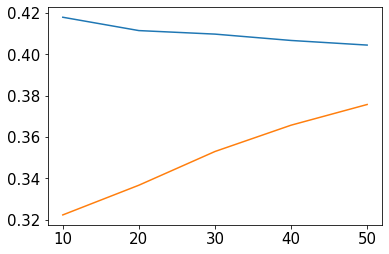

In [445]:
plt.plot(train_sizes,train_scores)
plt.plot(train_sizes,test_scores);

In [447]:
root_c_mat = sklearn.metrics.confusion_matrix(predict_valid,labels_valid[:,0])

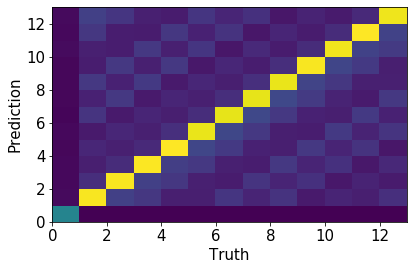

In [448]:
plt.pcolor(root_c_mat)
#plt.xticks(ticks=np.arange(0.5,11.5,1))
#plt.yticks(ticks=np.arange(0.5,11.5,1))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.rc('font', size=15)
plt.tight_layout()

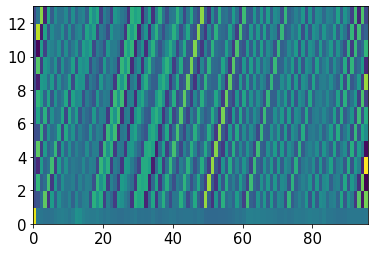

In [449]:
plt.pcolor(root_model.coef_)

### Train quality model on playground set

In [495]:
standard_features_play, standard_labels_play = chord_loader.standardize_root(
    features_play,labels_play,1,transposed=True)

In [496]:
quality_model = sklearn.linear_model.LogisticRegression(class_weight=None,multi_class='ovr',
                                                solver='lbfgs', max_iter=200)

quality_model.fit(standard_features_play, standard_labels_play[:,1]);
standard_predict_play = quality_model.predict(standard_features_play)

print(f"Quality F1 score: {sklearn.metrics.f1_score(standard_predict_play,standard_labels_play[:,1],average='weighted'):.3f}")

quality_c_mat = sklearn.metrics.confusion_matrix(standard_predict_play,standard_labels_play[:,1])

Quality F1 score: 0.853


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


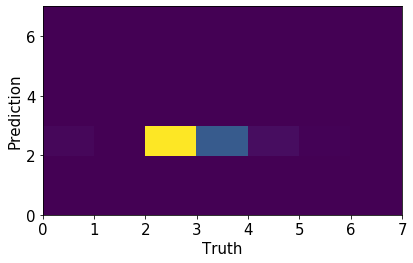

In [497]:
plt.pcolor(quality_c_mat)
#plt.xticks(ticks=np.arange(0.5,11.5,1))
#plt.yticks(ticks=np.arange(0.5,11.5,1))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.rc('font', size=15)
plt.tight_layout()

In [498]:
quality_c_mat

array([[    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [  215,    34, 13583,  3830,   438,    64,    27],
       [    1,     1,    18,    21,     2,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0]])

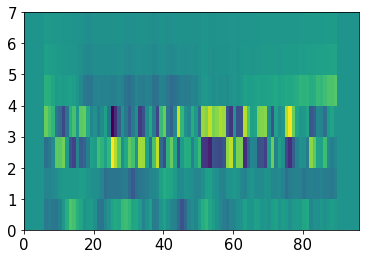

In [499]:
plt.pcolor(quality_model.coef_)

### Producing labels given youtube video

In [50]:
def download_mp3(link,destination):
    options = {
        'format': 'bestaudio/best', # choice of quality
        'extractaudio' : True,      # only keep the audio
        'audioformat' : "mp3",      # convert to mp3 
        'outtmpl': '%(id)s',        # name the file the ID of the video
        'noplaylist' : True,}       # only download single song, not playlist
    ydl = youtube_dl.YoutubeDL(options)

    with ydl:
        # download video
        try:
            result = ydl.extract_info(link, download=True)
            os.rename(result['id'], destination)

        except Exception as e:
            print("Can't download audio! %s\n" % traceback.format_exc())


In [113]:
download_mp3('https://www.youtube.com/watch?v=a__Y4dlP8eo','test.mp3')

[youtube] a__Y4dlP8eo: Downloading webpage
[youtube] a__Y4dlP8eo: Downloading video info webpage
[youtube] Downloading just video a__Y4dlP8eo because of --no-playlist
[download] Destination: a__Y4dlP8eo
[download] 100% of 4.08MiB in 00:0033MiB/s ETA 00:005


In [114]:
song_features = chord_loader.get_features("test.mp3",0.5,21.35,7,1)

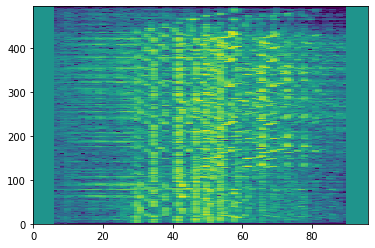

In [117]:
plt.pcolor(song_features);

In [ ]:
!rm test.mp3

## Setting up bash commands
Now that I've explored a bit, I'm setting up bash commands to process the mp3/chord files, and save the numpy arrays.  The arrays will be saved in `Data/processed/` as npy files.  There will also be a file `Data/processed/directory.csv` with basic info about settings used to process files.

The following command will process the data:

```python chord_process.py default_lr --transpose --standard```

After data is processed, I'm training linear regression models, and saving to directory `Models` as pickles.  I use the following command:

```python lr_train.py default_lr default_10 --weighted```

I'd also like to make learning curves, so I'll also execute the following:

```python lr_train.py default_lr default_08 --weighted --frac 0.8
python lr_train.py default_lr default_06 --weighted --frac 0.6
python lr_train.py default_lr default_04 --weighted --frac 0.4
python lr_train.py default_lr default_02 --weighted --frac 0.2```